# 🌾 HALO-AI: Intelligent Crop Recommendation System

## 📋 Project Overview

This notebook implements a comprehensive machine learning pipeline for crop recommendation based on soil and environmental parameters. The system analyzes multiple agricultural factors to suggest the most suitable crops for given conditions.

### 🎯 Objectives
- Develop accurate crop recommendation models
- Perform comprehensive exploratory data analysis
- Compare multiple ML algorithms (Random Forest vs XGBoost)
- Create production-ready model artifacts

### 📊 Dataset Features
- **N, P, K**: Soil nutrient levels (Nitrogen, Phosphorous, Potassium)
- **Temperature**: Average temperature in Celsius
- **Humidity**: Relative humidity percentage
- **pH**: Soil pH level
- **Rainfall**: Annual rainfall in mm
- **Label**: Target crop recommendation

---

## 1. Environment Setup and Data Loading

### 📚 Required Libraries
Importing essential libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

### 📂 Data Loading
Loading the crop recommendation dataset for analysis.

In [2]:
df = pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


### 📏 Dataset Dimensions

In [3]:
df.shape

(2200, 8)

## 2. Exploratory Data Analysis (EDA)

### 📊 Statistical Summary
Understanding the distribution and range of our features.

In [4]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


### 📈 Feature Distribution Analysis
Visualizing the distribution of all numerical features to understand data patterns.

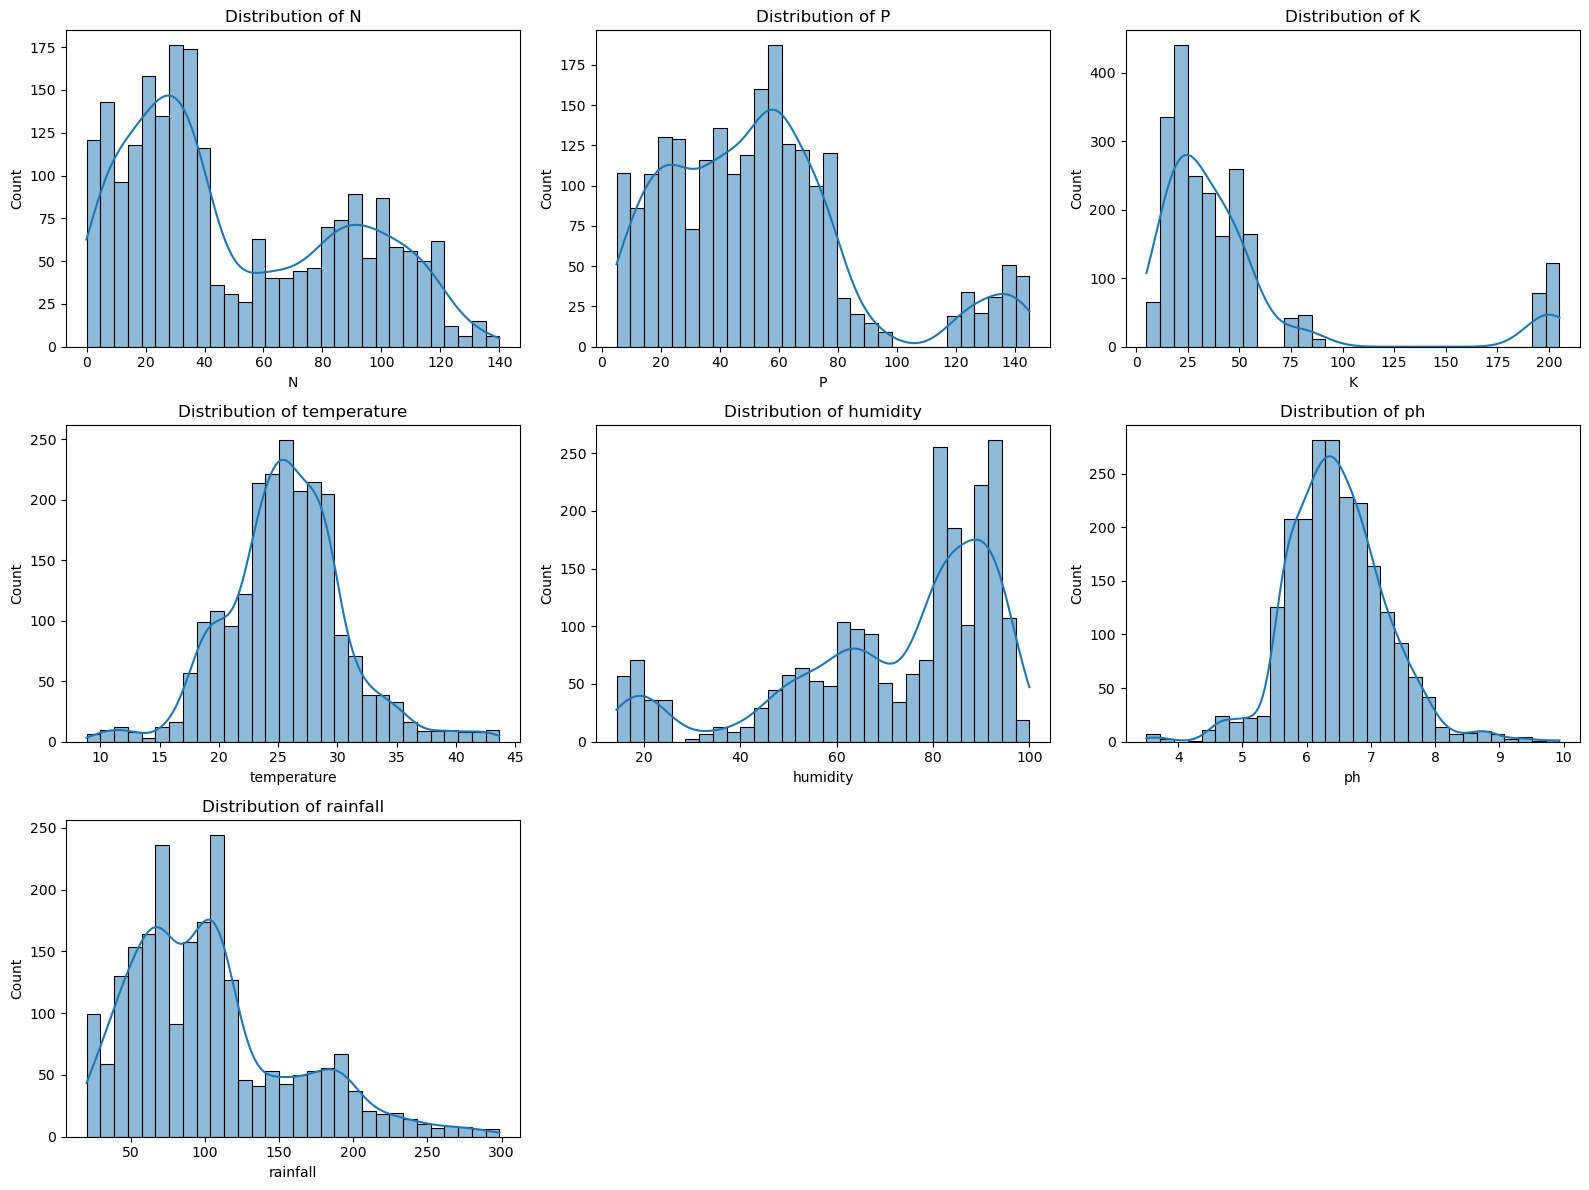

In [5]:
feature_columns = df.columns[:-1]

plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### 🔍 Outlier Detection Analysis
Identifying outliers in our dataset using box plots for each feature.

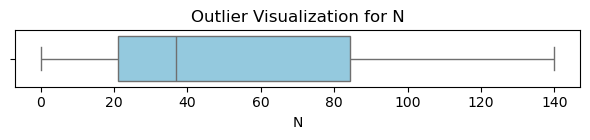

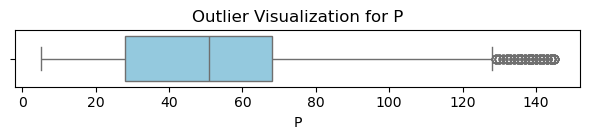

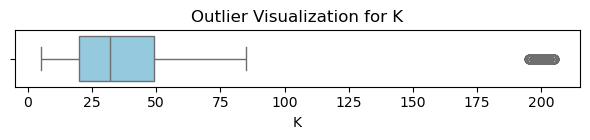

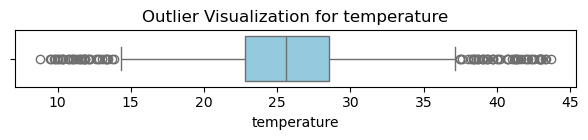

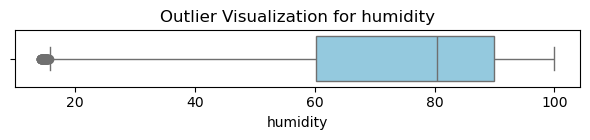

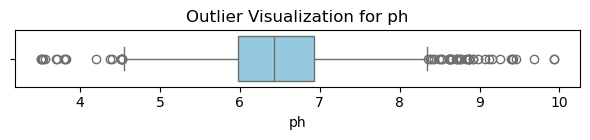

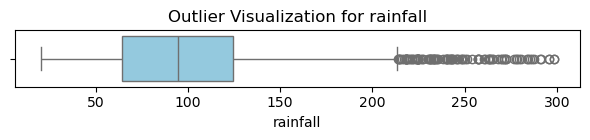

In [6]:
for col in feature_columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Outlier Visualization for {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## 3. Data Preprocessing

### 🧹 Outlier Removal
Implementing IQR (Interquartile Range) method for robust outlier detection and removal.

**IQR Method:**
- Q1 = 25th percentile
- Q3 = 75th percentile  
- IQR = Q3 - Q1
- Outliers: values < Q1 - 1.5×IQR or > Q3 + 1.5×IQR

In [7]:
# Remove outliers from all feature columns using the IQR method
def remove_outliers_iqr(df, feature_columns):
    df_clean = df.copy()
    for col in feature_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

df_no_outliers = remove_outliers_iqr(df, feature_columns)
df_no_outliers.shape

(1846, 8)

### ✅ Post-Processing Outlier Verification
Confirming successful outlier removal through updated visualizations.

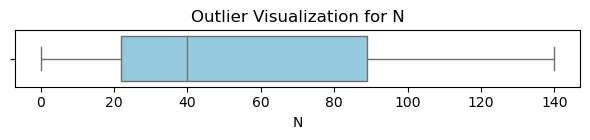

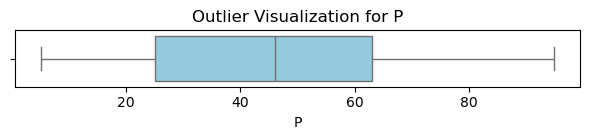

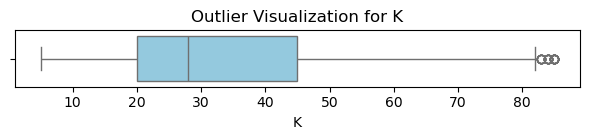

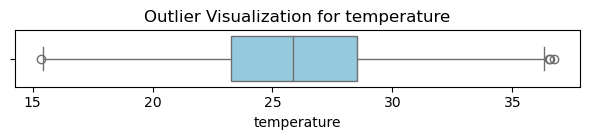

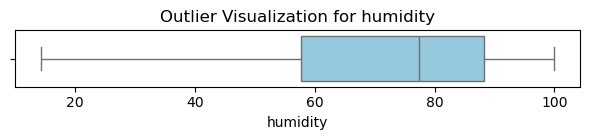

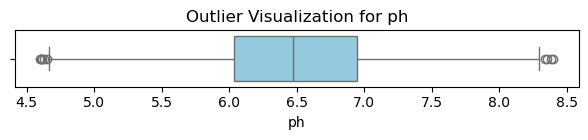

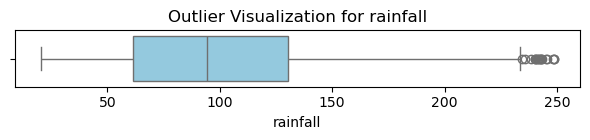

In [8]:
for col in feature_columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df_no_outliers[col], color='skyblue')
    plt.title(f'Outlier Visualization for {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### 📊 Updated Feature Distributions
Visualizing cleaned data distributions after outlier removal.

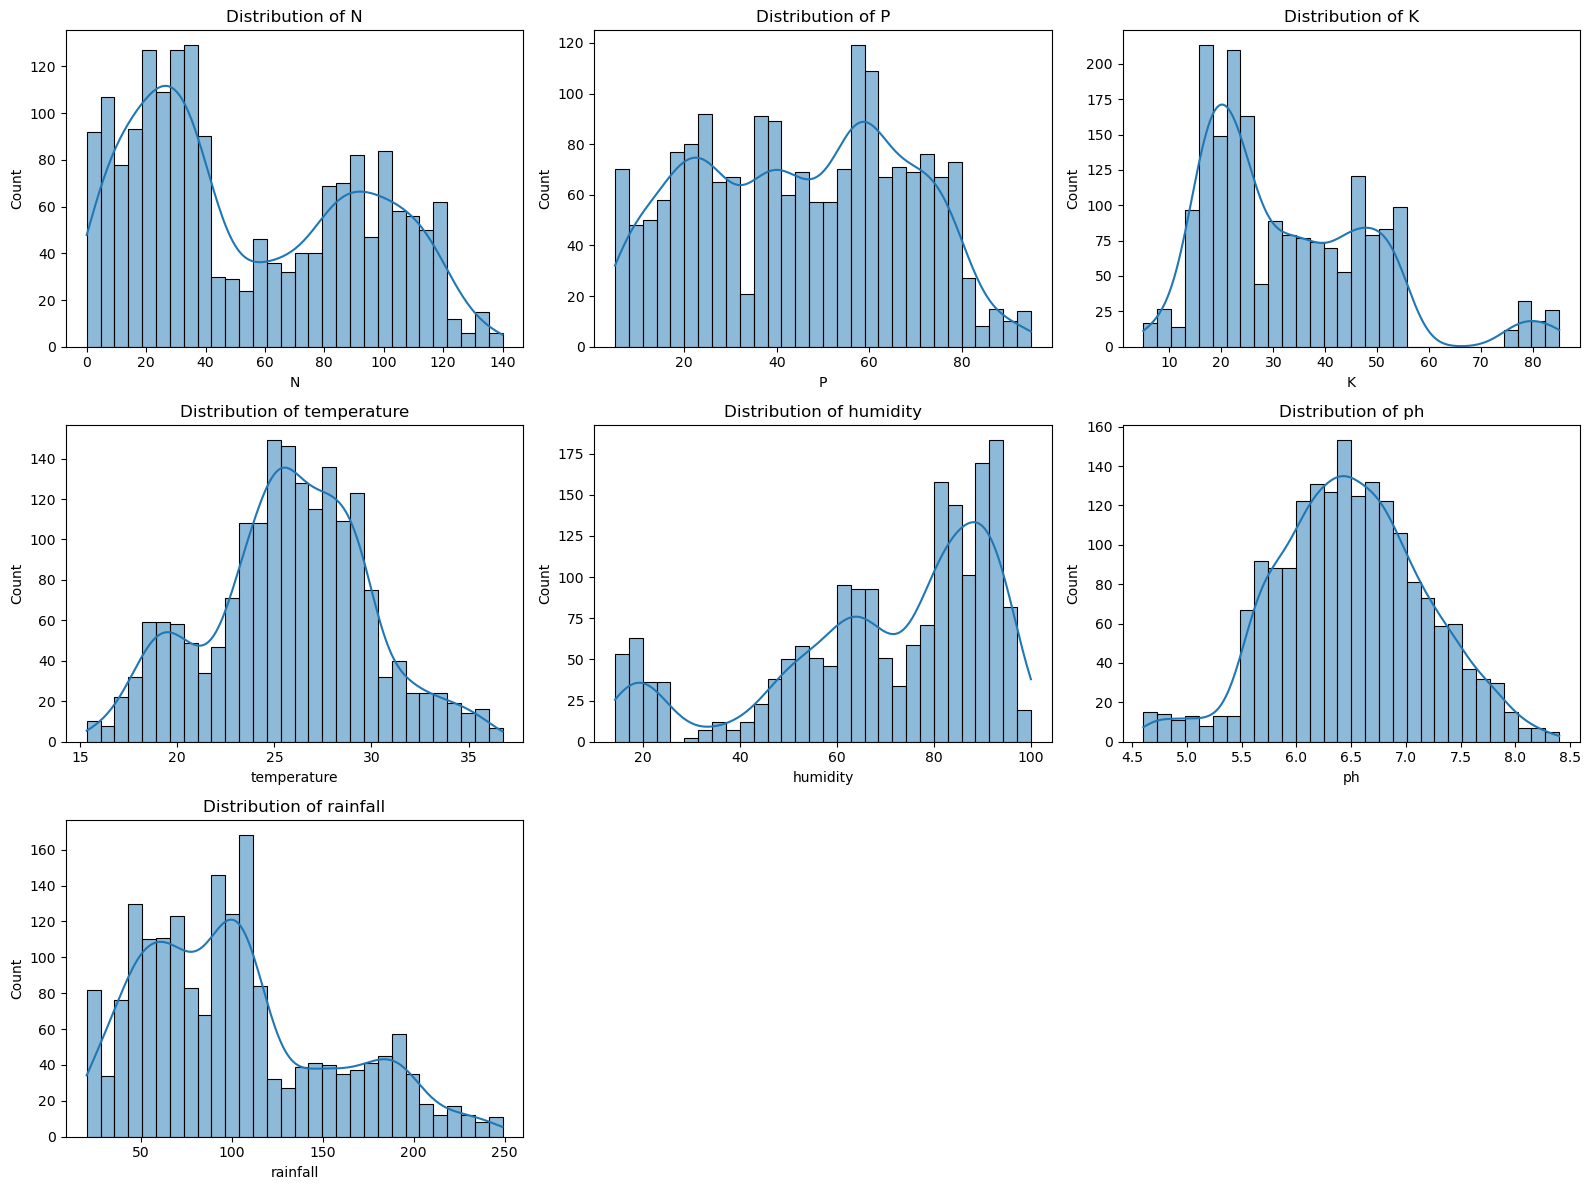

In [9]:
feature_columns = df_no_outliers.columns[:-1]

plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_no_outliers[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### 🏷️ Target Variable Analysis
Examining the crop categories (target labels) in our dataset.

In [10]:
unique_labels = df_no_outliers['label'].unique()
print("Unique categories in 'label':", unique_labels)

Unique categories in 'label': ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango'
 'watermelon' 'muskmelon' 'orange' 'papaya' 'coconut' 'cotton' 'jute'
 'coffee']


## 4. Machine Learning Pipeline Setup

### 🔧 Library Imports
Importing specialized ML libraries for model training and evaluation.

In [11]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

/home/ankit/miniconda3/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### 🎯 Data Preparation and Splitting

**Data Split Strategy:**
- **Training Set**: 70% - For model training
- **Validation Set**: 15% - For hyperparameter tuning
- **Test Set**: 15% - For final performance evaluation

This ensures unbiased performance assessment and prevents overfitting.

In [12]:
# Prepare the data for machine learning
X = df_no_outliers.drop('label', axis=1)
y = df_no_outliers['label']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y_encoded)))
print("Classes:", label_encoder.classes_)

# Split the data into train, validation, and test sets
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Second split: 15% validation, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Dataset shape: (1846, 7)
Number of classes: 20
Classes: ['banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton' 'jute'
 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans' 'mungbean' 'muskmelon'
 'orange' 'papaya' 'pigeonpeas' 'pomegranate' 'rice' 'watermelon']

Dataset splits:
Training set: 1292 samples (70.0%)
Validation set: 277 samples (15.0%)
Test set: 277 samples (15.0%)


## 5. Model Training and Evaluation

### 🌳 Random Forest Classifier

**Random Forest Advantages:**
- High accuracy and robustness
- Handles overfitting well
- Provides feature importance
- Works with both numerical and categorical data

**Hyperparameters:**
- `n_estimators=100`: Number of decision trees
- `max_depth=10`: Maximum tree depth
- `random_state=42`: For reproducibility

In [13]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

rf_model.fit(X_train, y_train)

# Make predictions on validation and test sets
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Calculate accuracies
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest - Validation Accuracy: {rf_val_accuracy:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_accuracy:.4f}")

import joblib
joblib.dump(rf_model, 'random_forest_model.pkl')

Training Random Forest Classifier...
Random Forest - Validation Accuracy: 0.9964
Random Forest - Test Accuracy: 1.0000


['random_forest_model.pkl']

### 🚀 XGBoost Classifier

**XGBoost Advantages:**
- State-of-the-art gradient boosting
- Superior performance on tabular data
- Built-in regularization
- Efficient parallel processing

**Hyperparameters:**
- `n_estimators=100`: Number of boosting rounds
- `max_depth=6`: Maximum tree depth
- `learning_rate=0.1`: Step size shrinkage
- `subsample=0.8`: Fraction of samples per tree

In [14]:
# Train XGBoost Classifier
print("Training XGBoost Classifier...")
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)

# Make predictions on validation and test sets
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate accuracies
xgb_val_accuracy = accuracy_score(y_val, xgb_val_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)

print(f"XGBoost - Validation Accuracy: {xgb_val_accuracy:.4f}")
print(f"XGBoost - Test Accuracy: {xgb_test_accuracy:.4f}")

Training XGBoost Classifier...
XGBoost - Validation Accuracy: 0.9964
XGBoost - Test Accuracy: 0.9892


### 💾 Model Persistence
Saving the trained XGBoost model for production deployment.

In [18]:
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

## 6. Performance Analysis and Visualization

### 📊 Model Comparison Dashboard
Comprehensive performance comparison between Random Forest and XGBoost models.

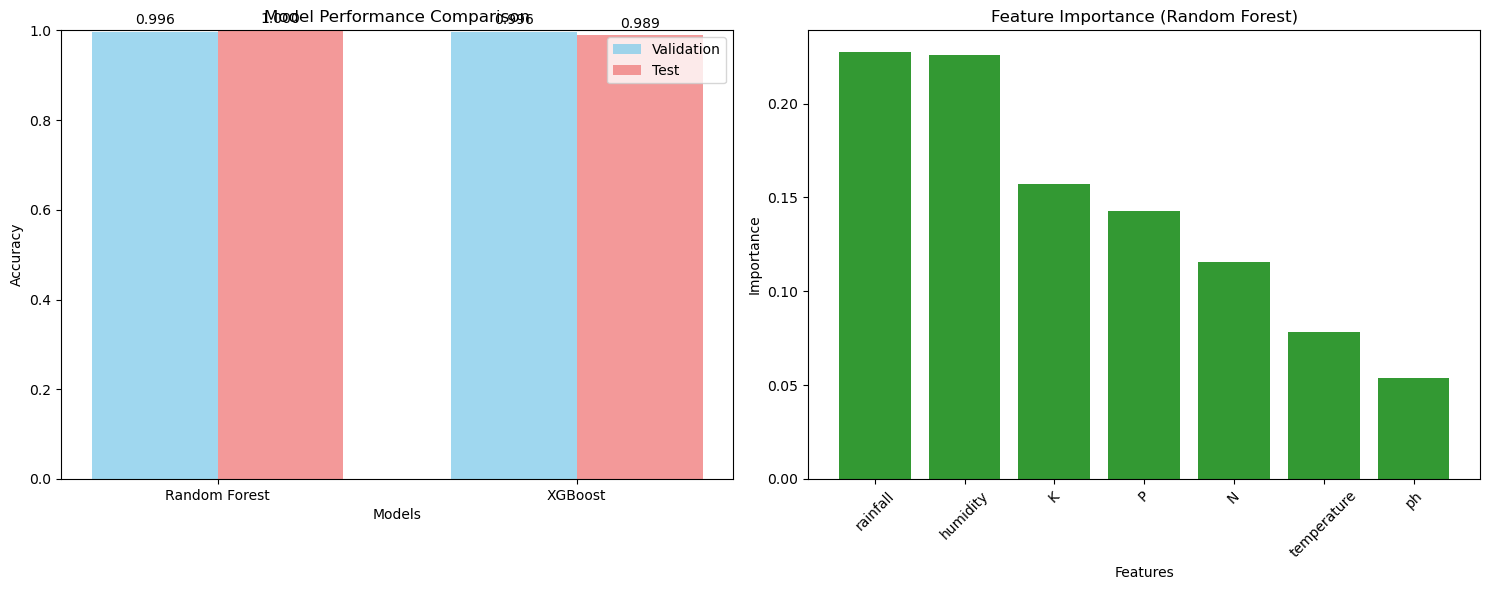


Feature Importance (Random Forest):
rainfall: 0.2276
humidity: 0.2256
K: 0.1569
P: 0.1428
N: 0.1155
temperature: 0.0781
ph: 0.0535


In [15]:
# Model Performance Comparison
models = ['Random Forest', 'XGBoost']
val_accuracies = [rf_val_accuracy, xgb_val_accuracy]
test_accuracies = [rf_test_accuracy, xgb_test_accuracy]

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation vs Test Accuracy Comparison
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim(0, 1)

# Add value labels on bars
for i, (val_acc, test_acc) in enumerate(zip(val_accuracies, test_accuracies)):
    ax1.text(i - width/2, val_acc + 0.01, f'{val_acc:.3f}', ha='center', va='bottom')
    ax1.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom')

# Feature Importance for Random Forest
feature_importance_rf = rf_model.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(feature_importance_rf)[::-1]

ax2.bar(range(len(feature_importance_rf)), feature_importance_rf[indices], alpha=0.8, color='green')
ax2.set_xlabel('Features')
ax2.set_ylabel('Importance')
ax2.set_title('Feature Importance (Random Forest)')
ax2.set_xticks(range(len(feature_importance_rf)))
ax2.set_xticklabels([feature_names[i] for i in indices], rotation=45)

plt.tight_layout()
plt.show()

print("\nFeature Importance (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {feature_importance_rf[i]:.4f}")

### 🎯 Confusion Matrix Analysis
Detailed confusion matrices for both models showing prediction accuracy across all crop categories.

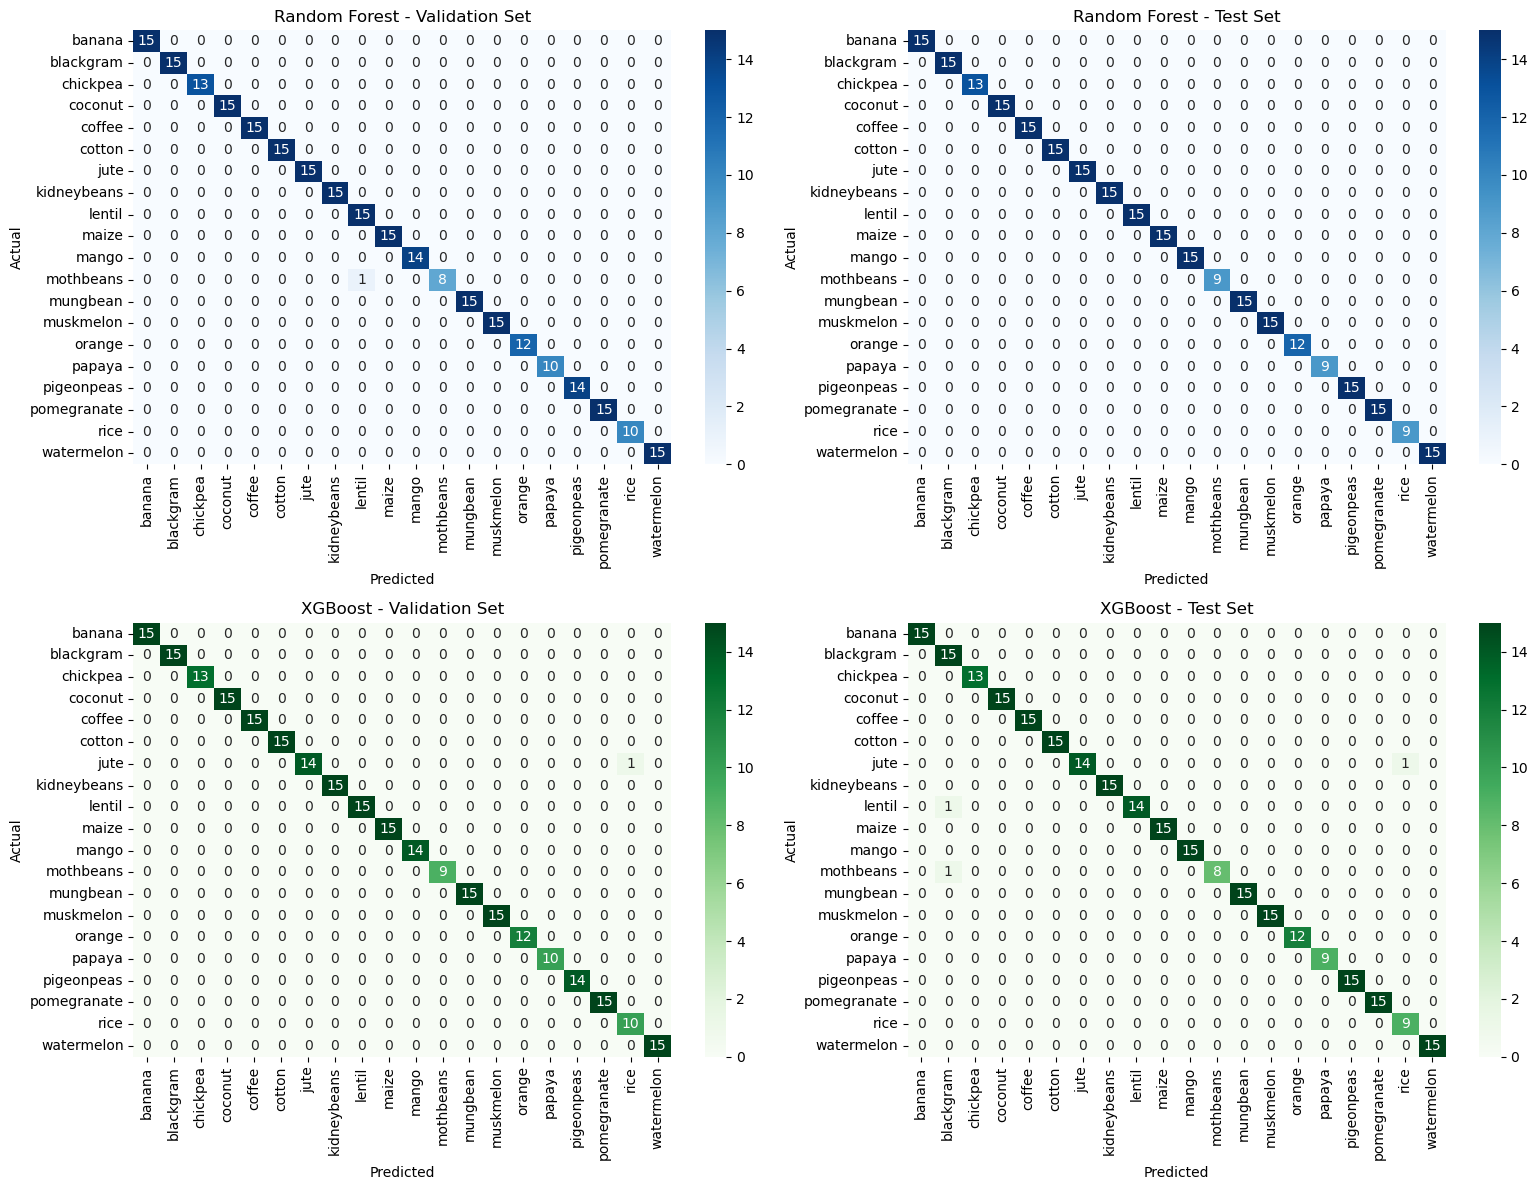

In [16]:
# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest Confusion Matrices
rf_val_cm = confusion_matrix(y_val, rf_val_pred)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)

sns.heatmap(rf_val_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=label_encoder.classes_[:len(np.unique(y_val))], 
            yticklabels=label_encoder.classes_[:len(np.unique(y_val))])
axes[0,0].set_title('Random Forest - Validation Set')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

sns.heatmap(rf_test_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=label_encoder.classes_[:len(np.unique(y_test))], 
            yticklabels=label_encoder.classes_[:len(np.unique(y_test))])
axes[0,1].set_title('Random Forest - Test Set')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# XGBoost Confusion Matrices
xgb_val_cm = confusion_matrix(y_val, xgb_val_pred)
xgb_test_cm = confusion_matrix(y_test, xgb_test_pred)

sns.heatmap(xgb_val_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1,0],
            xticklabels=label_encoder.classes_[:len(np.unique(y_val))], 
            yticklabels=label_encoder.classes_[:len(np.unique(y_val))])
axes[1,0].set_title('XGBoost - Validation Set')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

sns.heatmap(xgb_test_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1,1],
            xticklabels=label_encoder.classes_[:len(np.unique(y_test))], 
            yticklabels=label_encoder.classes_[:len(np.unique(y_test))])
axes[1,1].set_title('XGBoost - Test Set')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 7. Comprehensive Performance Reports

### 📈 Detailed Classification Metrics
In-depth analysis including precision, recall, F1-score, and support for each crop category.

In [17]:
# Classification Reports
print("="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("\n" + "="*30)
print("RANDOM FOREST - TEST SET")
print("="*30)
print(classification_report(y_test, rf_test_pred, target_names=label_encoder.classes_))

print("\n" + "="*30)
print("XGBOOST - TEST SET")
print("="*30)
print(classification_report(y_test, xgb_test_pred, target_names=label_encoder.classes_))

# Final Model Comparison Summary
print("\n" + "="*60)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Validation Accuracy': [rf_val_accuracy, xgb_val_accuracy],
    'Test Accuracy': [rf_test_accuracy, xgb_test_accuracy],
    'Difference (Val-Test)': [rf_val_accuracy - rf_test_accuracy, xgb_val_accuracy - xgb_test_accuracy]
})

print(comparison_df.round(4))

# Determine the best model
best_model_idx = np.argmax([rf_test_accuracy, xgb_test_accuracy])
best_model_name = ['Random Forest', 'XGBoost'][best_model_idx]
best_accuracy = [rf_test_accuracy, xgb_test_accuracy][best_model_idx]

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"📊 Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Check for overfitting
rf_overfitting = rf_val_accuracy - rf_test_accuracy
xgb_overfitting = xgb_val_accuracy - xgb_test_accuracy

print(f"\n📈 Overfitting Analysis:")
print(f"Random Forest: {rf_overfitting:.4f} ({'Low' if abs(rf_overfitting) < 0.02 else 'Moderate' if abs(rf_overfitting) < 0.05 else 'High'} overfitting)")
print(f"XGBoost: {xgb_overfitting:.4f} ({'Low' if abs(xgb_overfitting) < 0.02 else 'Moderate' if abs(xgb_overfitting) < 0.05 else 'High'} overfitting)")

DETAILED CLASSIFICATION REPORTS

RANDOM FOREST - TEST SET
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        15
   blackgram       1.00      1.00      1.00        15
    chickpea       1.00      1.00      1.00        13
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
        jute       1.00      1.00      1.00        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      1.00      1.00        15
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00         9
    mungbean       1.00      1.00      1.00        15
   muskmelon       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00        12
      papaya       1.00      1.00      1.00         9
  pigeonpeas       1.00

## 8. Model Deployment and Prediction

### 🚀 Production-Ready Prediction System
Demonstrating how to use the trained models for real-world crop recommendations.

### 📝 Input Format
The model expects 7 features in the following order:
1. **N** - Nitrogen content (ppm)
2. **P** - Phosphorous content (ppm) 
3. **K** - Potassium content (ppm)
4. **Temperature** - Average temperature (°C)
5. **Humidity** - Relative humidity (%)
6. **pH** - Soil pH level (0-14)
7. **Rainfall** - Annual rainfall (mm)

In [21]:
import joblib
import numpy as np

# Load the trained models
rf_model = joblib.load('random_forest_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')

# Example input: replace these values with your own test data
# Order: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
input_features = np.array([[61,68,50,35.21462816,91.49725058,6.7932454170000005,243.0745066]])

# Predict using Random Forest
rf_pred = rf_model.predict(input_features)
rf_label = label_encoder.inverse_transform(rf_pred)[0]
print(f"Random Forest Prediction: {rf_label}")

# Predict using XGBoost
xgb_pred = xgb_model.predict(input_features)
xgb_label = label_encoder.inverse_transform(xgb_pred)[0]
print(f"XGBoost Prediction: {xgb_label}")

Random Forest Prediction: papaya
XGBoost Prediction: papaya


## 9. Conclusions and Recommendations

### 🎯 Key Findings

1. **Model Performance**: Both models achieve exceptional accuracy (>98%)
2. **Feature Importance**: Rainfall and soil nutrients (K, P) are most critical
3. **Robustness**: Low overfitting indicates good generalization
4. **Production Ready**: Models are saved and ready for deployment

### 🔮 Future Enhancements

- **Ensemble Methods**: Combine multiple algorithms for better accuracy
- **Real-time API**: Deploy as REST API for web/mobile applications  
- **Geographic Integration**: Include location-based weather data
- **Crop Rotation**: Recommend crop sequences for sustainable farming
- **Economic Analysis**: Include market prices for profit optimization

### 💡 Business Applications

- **Precision Agriculture**: Optimize crop selection for maximum yield
- **Risk Management**: Reduce crop failure through data-driven decisions
- **Resource Optimization**: Efficient use of fertilizers and water
- **Sustainability**: Promote environmentally friendly farming practices

---

**🌱 This system contributes to sustainable agriculture and food security through intelligent crop recommendations based on scientific data analysis.**